In [1]:
from assaytools import platereader
import matplotlib.pyplot as plt
import string
import numpy as np
from glob import glob

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
file_set = {'Src': glob("Src/*.xml"),
        'SrcGK': glob("SrcT338I/*.xml"),
        'AblGK': glob("AblT334I/*.xml"),
        'Abl': glob("Abl/*.xml")}
ligands = ['Bosutinib','Bosutinib Isomer','Erlotinib','Gefitinib']

In [4]:
file_set['Src']

['Src/Src_Bos_20151215_bw2020_gain120_161211.xml',
 'Src/Src_BosI_20151215_bw2020_gain120_163633.xml',
 'Src/Src_Erl_20151215_bw2020_gain120_170056.xml',
 'Src/Src_Gef_20151215_bw2020_gain120_172518.xml']

In [5]:
Src_Spectra = platereader.read_icontrol_xml(file_set['Src'][0])
for file in file_set['Src']:
    print file
    new_dict = platereader.read_icontrol_xml(file)
    for key in Src_Spectra:
        Src_Spectra[key] = dict(Src_Spectra[key].items()+new_dict[key].items())
   

Src/Src_Bos_20151215_bw2020_gain120_161211.xml
Src/Src_BosI_20151215_bw2020_gain120_163633.xml
Src/Src_Erl_20151215_bw2020_gain120_170056.xml
Src/Src_Gef_20151215_bw2020_gain120_172518.xml


In [6]:
Src_Spectra.keys()

['em280', 'abs', 'em340']

In [7]:
SrcErl = platereader.select_data(Src_Spectra, 'em280', 'E', wavelength='480')
SrcErlLig = platereader.select_data(Src_Spectra, 'em280', 'F', wavelength='480')

In [8]:
well = dict()
for j in string.ascii_uppercase:
    for i in range(1,25):
        well['%s' %j + '%s' %i] = i

In [9]:
# Stated concentrations of protein and ligand.
#ligand_conc from before
Lstated = np.array([20.0e-6,9.15e-6,4.18e-6,1.91e-6,0.875e-6,0.4e-6,0.183e-6,0.0837e-6,0.0383e-6,0.0175e-6,0.008e-6,0.0001e-6], np.float64) # ligand concentration, M
Pstated = 1.0e-6 * np.ones([12],np.float64) # protein concentration, M
# Protein concentration (M) (modified form from Sonya, eliminating last measurement because we can't deal with zero ligand concentrations yet)

In [10]:

# Assay configuration details
import math
assay_volume = 100e-6 # assay volume, L
well_area = 0.3969 # well area, cm^2 for 4ti-0223 [http://4ti.co.uk/files/1614/0542/7662/4ti-0223_Marketing_Drawing.pdf]
path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections     

# Uncertainties in protein and ligand concentrations.
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [11]:
def reorder2list(data,wells):
    
    sorted_keys = sorted(well.keys(), key=lambda k:well[k])
    
    reorder_data = []
    
    for key in sorted_keys:
        try:
            reorder_data.append(data[key])
        except:
            pass
        
    reorder_data = np.asarray(reorder_data,np.float64)
    
    return reorder_data

In [12]:
def quick_model(protein_data, buffer_data,name):
    reorder_protein = reorder2list(protein_data,well)
    reorder_buffer = reorder2list(buffer_data,well)
    
    print name   
 
    from assaytools import pymcmodels
    pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=reorder_protein,
               top_ligand_fluorescence=reorder_buffer,
               use_primary_inner_filter_correction=True, 
               use_secondary_inner_filter_correction=True, 
               assay_volume=assay_volume, DG_prior='uniform')
    
    mcmc = pymcmodels.run_mcmc(pymc_model)
    
    from assaytools import plots
    figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)
    
    map = pymcmodels.map_fit(pymc_model)
    
    pymcmodels.show_summary(pymc_model, map, mcmc)
    
    DeltaG = map.DeltaG.value
    
    np.save('DeltaG_%s.npy'%name,DeltaG)
    np.save('DeltaG_trace_%s.npy'%name,mcmc.DeltaG.trace())
    
    import pymc
    
    M = pymc.MCMC(pymc_model, db='pickle', dbname='pymc_model_%s.pickle'%name)
    M.db
    M.sample(10)
    M.db.close()

Src_Erl_spectra
MAP fitting cycle 5/5
DeltaG = -16.3 +- 3.0 kT
Kd = 79.7 nM +- 295.5 nM
 [-----------------100%-----------------] 10 of 10 complete in 0.0 sec

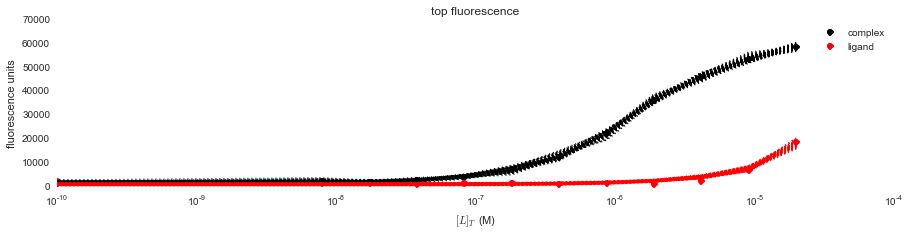

In [13]:
quick_model(SrcErl,SrcErlLig,'Src_Erl_spectra')

In [14]:
import pymc

db = pymc.database.pickle.load('pymc_model_Src_Erl_spectra.pickle')

In [15]:
db.DeltaG()

array([-16.34470026, -16.34470026, -16.34470026, -16.34470026,
       -16.34470026, -16.34470026, -16.34470026, -16.34470026,
       -16.34470026, -16.34470026])

In [16]:
from assaytools import plots

In [17]:
plots.plot_measurements(Lstated,Pstated,path_length,db)

/Users/hansons/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1024: UserWarning: Unable to find pixel distance along axis for                    interval padding of ticks; assuming no interval padding                    needed.
  needed.")
/Users/hansons/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1034: UserWarning: Unable to find pixel distance along axis for                    interval padding of ticks; assuming no interval padding                    needed.
  needed.")


RuntimeError: Error building image

RuntimeError: Error building image

In [18]:
def plots_model(protein_data, buffer_data,name):
    reorder_protein = reorder2list(protein_data,well)
    reorder_buffer = reorder2list(buffer_data,well)
    
    print name   
 
    from assaytools import pymcmodels
    pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=reorder_protein,
               top_ligand_fluorescence=reorder_buffer,
               use_primary_inner_filter_correction=True, 
               use_secondary_inner_filter_correction=True, 
               assay_volume=assay_volume, DG_prior='uniform')
    
    mcmc = pymcmodels.run_mcmc(pymc_model)
    
    from assaytools import plots
    figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)
    
    map = pymcmodels.map_fit(pymc_model)
    
    pymcmodels.show_summary(pymc_model, map, mcmc)
    
    DeltaG = map.DeltaG.value
    
    np.save('DeltaG_%s.npy'%name,DeltaG)
    np.save('DeltaG_trace_%s.npy'%name,mcmc.DeltaG.trace())
    
    from assaytools import plots
    plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)

Src_Erl_spectra
MAP fitting cycle 5/5
DeltaG = -14.4 +- 0.5 kT
Kd = 545.1 nM +- 597.3 nM
(1000,)


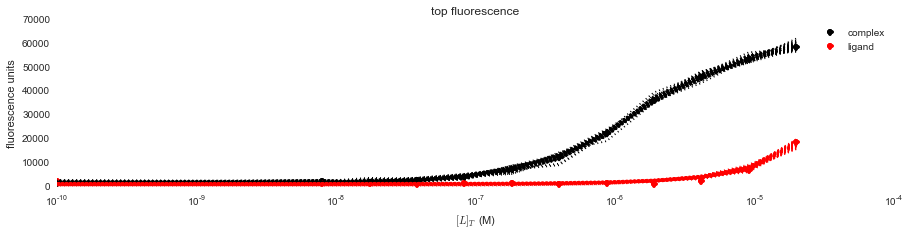

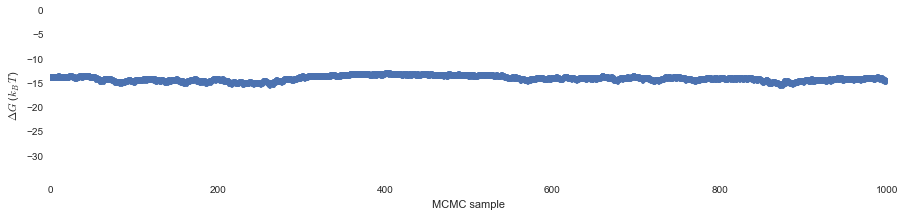

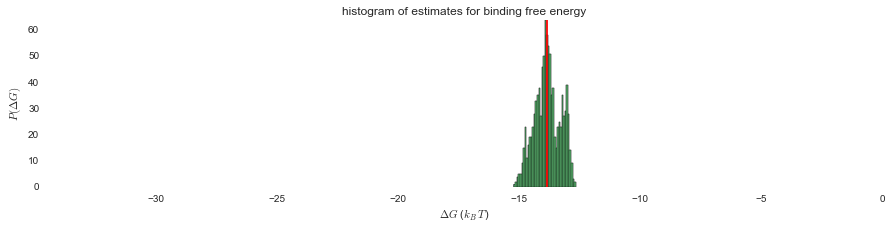

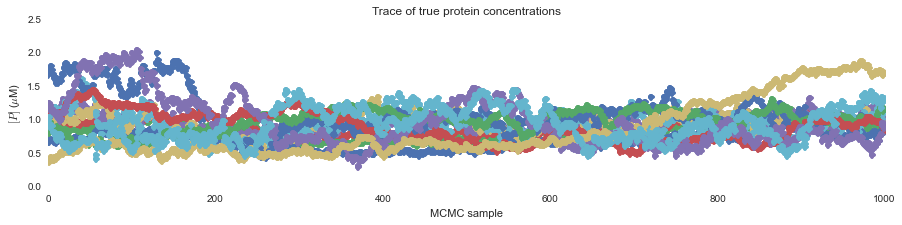

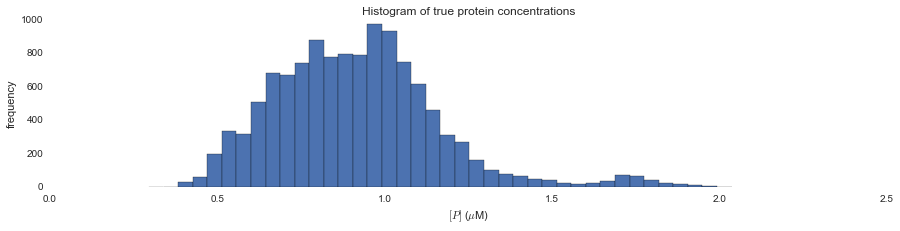

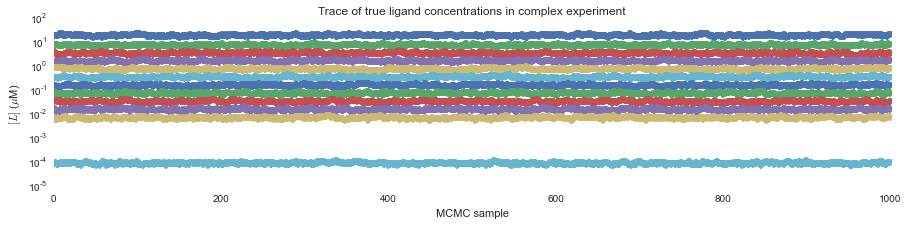

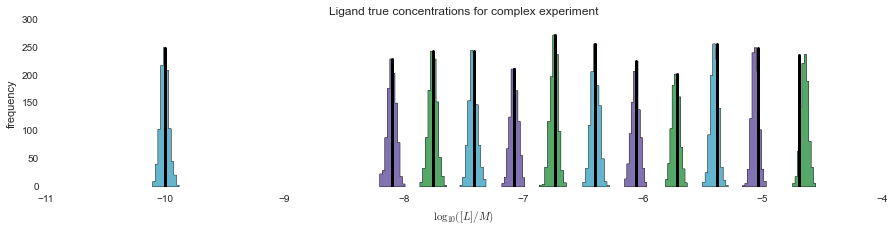

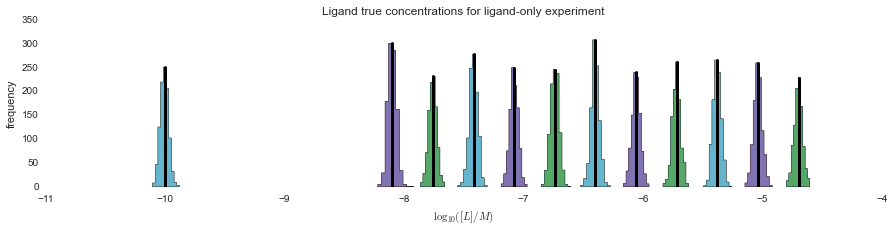

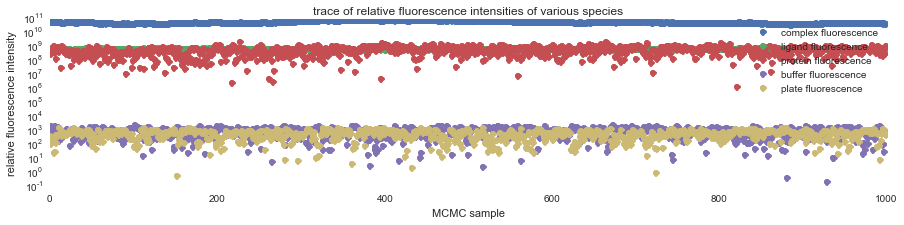

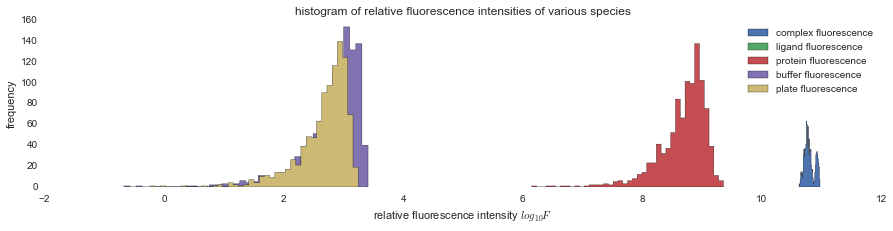

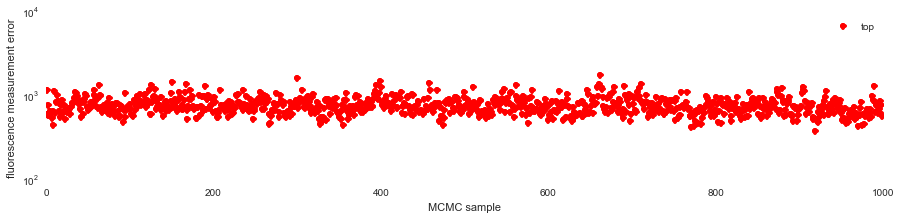

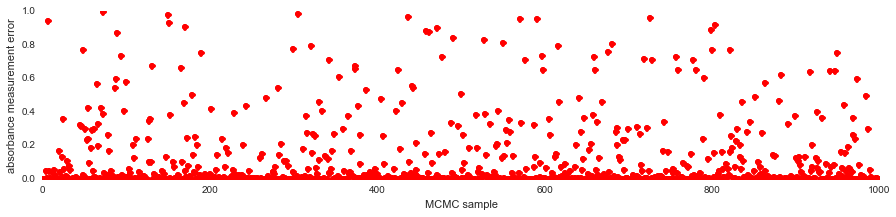

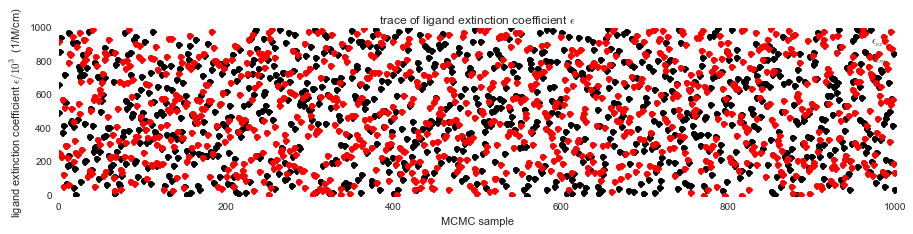

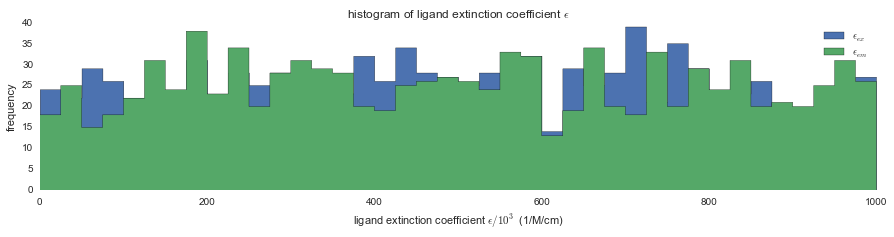

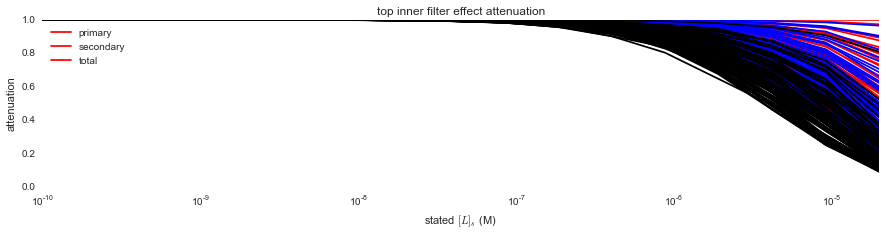

In [19]:
plots_model(SrcErl,SrcErlLig,'Src_Erl_spectra')

In [20]:
DeltaG_trace_Src_Erl_spectra = np.load('DeltaG_trace_Src_Erl_spectra.npy')


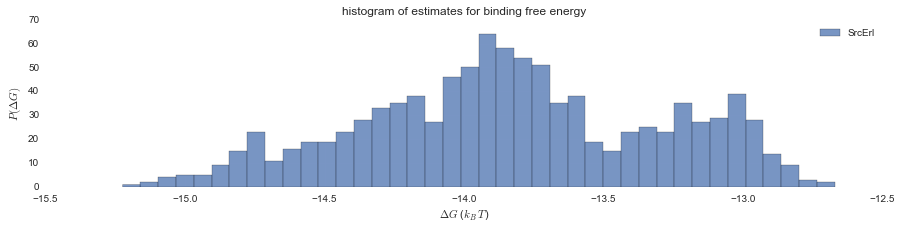

In [28]:
plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl')
#plt.plot([DeltaG_trace_Src_Erl_spectra.mean(),DeltaG_trace_Src_Erl_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

In [22]:
ls

Abl/                                            Simple Spectra Import Clean w Dictionary.ipynb
AblT334I/                                       Simple Spectra Import Clean.ipynb
Analysis.ipynb                                  Simple Spectra Import.ipynb
DeltaG_Src_Bsi_spectra.npy                      Spectra-Analysis.ipynb
DeltaG_Src_Erl_spectra.npy                      Src/
DeltaG_Src_Gef_spectra.npy                      SrcT338I/
DeltaG_trace_Src_Bsi_spectra.npy                Test.ipynb
DeltaG_trace_Src_Erl_spectra.npy                Thoughts.ipynb
DeltaG_trace_Src_Gef_spectra.npy                pymc_model_Src_Erl_spectra.pickle
README.md                                       pymc_model_Src_Gef_spectra.pickle


In [29]:
DeltaG = np.load('DeltaG_Src_Erl_spectra.npy')

In [30]:
DeltaG 

array(-14.422382614092243)

In [31]:
DeltaG_trace_Src_Erl_spectra.mean()

-13.834389287608321

### Hmmm....

In [32]:
SrcBsi = platereader.select_data(Src_Spectra, 'em280', 'C', wavelength='480')
SrcBsiLig = platereader.select_data(Src_Spectra, 'em280', 'D', wavelength='480')

Src_Bsi_spectra
MAP fitting cycle 5/5
DeltaG = -19.0 +- 5.8 kT
Kd = 5.7 nM +- 38.5 nM
 [-----------------100%-----------------] 10 of 10 complete in 0.0 sec

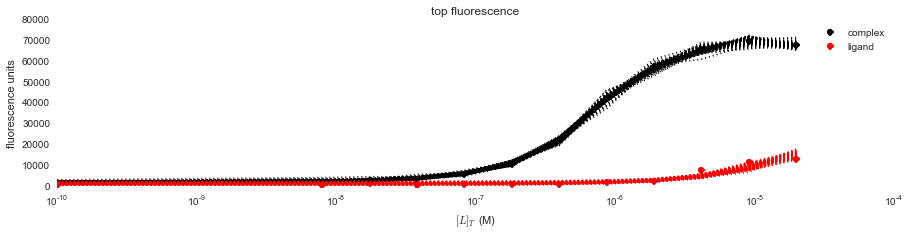

In [33]:
quick_model(SrcBsi,SrcBsiLig,'Src_Bsi_spectra')

In [34]:
DeltaG_trace_Src_Bsi_spectra = np.load('DeltaG_trace_Src_Bsi_spectra.npy')

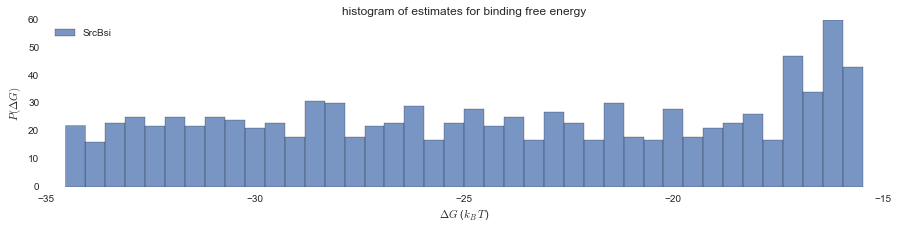

In [35]:
plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
#plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
#plt.plot([DeltaG_trace_Src_Bsi_spectra.mean(),DeltaG_trace_Src_Bsi_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

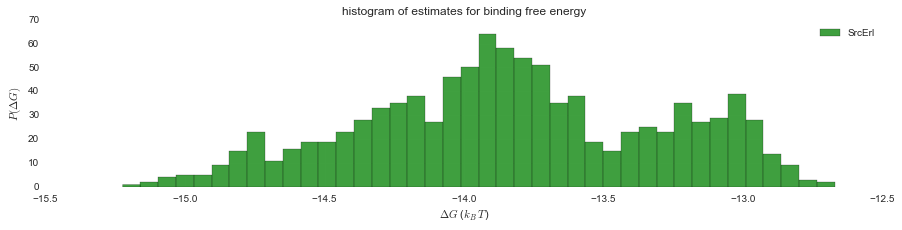

In [36]:
#plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
#plt.plot([DeltaG_trace_Src_Bsi_spectra.mean(),DeltaG_trace_Src_Bsi_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

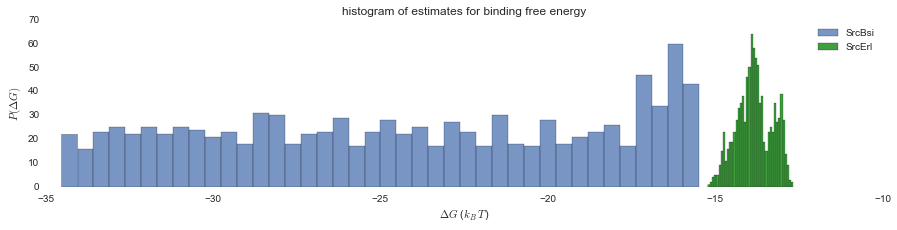

In [37]:
plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
#plt.plot([DeltaG_trace_Src_Bsi_spectra.mean(),DeltaG_trace_Src_Bsi_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

In [38]:
SrcBos = platereader.select_data(Src_Spectra, 'em280', 'A', wavelength='480')
SrcBosLig = platereader.select_data(Src_Spectra, 'em280', 'B', wavelength='480')

In [39]:
quick_model(SrcBos,SrcBosLig,'Src_Bos_spectra')

ValueError: could not convert string to float: OVER

In [40]:
SrcGef = platereader.select_data(Src_Spectra, 'em280', 'G', wavelength='480')
SrcGefLig = platereader.select_data(Src_Spectra, 'em280', 'H', wavelength='480')

Src_Gef_spectra
MAP fitting cycle 5/5
DeltaG = -12.5 +- 0.2 kT
Kd = 3.8 uM +- 0.8 uM
 [-----------------100%-----------------] 10 of 10 complete in 0.0 sec

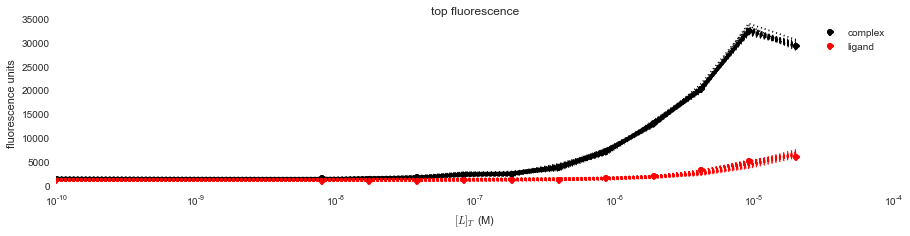

In [41]:
quick_model(SrcGef,SrcGefLig,'Src_Gef_spectra')

In [42]:
DeltaG_trace_Src_Gef_spectra = np.load('DeltaG_trace_Src_Gef_spectra.npy')

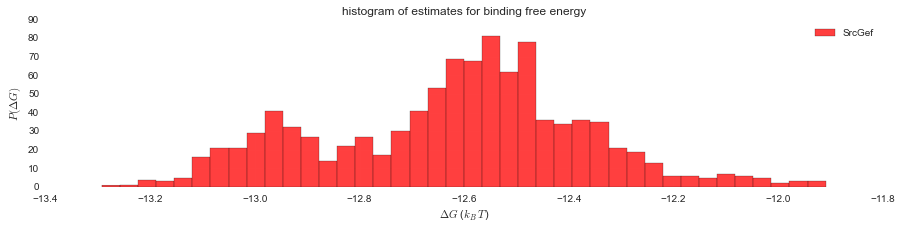

In [43]:
#plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
#plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
plt.hist(DeltaG_trace_Src_Gef_spectra, 40, alpha=0.75, label='SrcGef', color='r')
#plt.plot([DeltaG_trace_Src_Bsi_spectra.mean(),DeltaG_trace_Src_Bsi_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

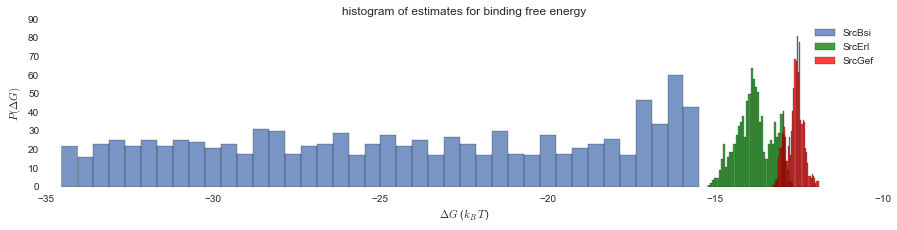

In [44]:
plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
plt.hist(DeltaG_trace_Src_Gef_spectra, 40, alpha=0.75, label='SrcGef', color='r')
#plt.plot([DeltaG_trace_Src_Bsi_spectra.mean(),DeltaG_trace_Src_Bsi_spectra.mean()],[0, 45],'b-')
#plt.plot([literature_Bos,literature_Bos],[0, 350],'r-',label='IUPHARM data')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

### Why are these multi modal?

In [45]:
Test_DG = -17.43

In [47]:
np.exp(Test_DG)

2.6930671376578519e-08

In [49]:
np.log(np.exp(Test_DG))

-17.43

###Let's see how these values compare to values from iupharm database

In [52]:
Src_erlotinib = 700e-9 # 700 nM

In [53]:
Src_gefitinib = 3800e-9 # 3800 nM

In [60]:
#Note these values are in the csv files in data/literature_affinity, but I haven't found the best way of parsing them yet.

In [54]:
np.log(Src_erlotinib)

-14.172185501903007

In [55]:
np.log(Src_gefitinib)

-12.480509491231935

In [56]:
SrcErl_dG = np.log(Src_erlotinib)

In [57]:
SrcGef_dG = np.log(Src_gefitinib)

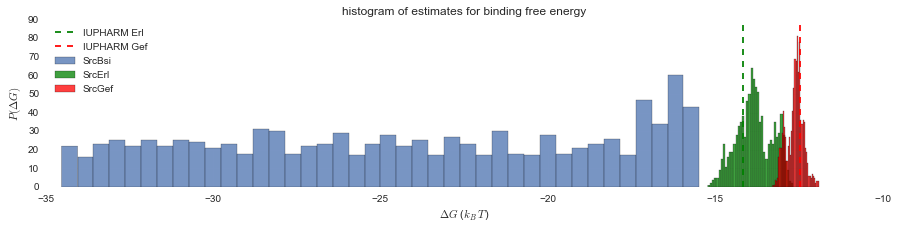

In [59]:
plt.hist(DeltaG_trace_Src_Bsi_spectra, 40, alpha=0.75, label='SrcBsi')
plt.hist(DeltaG_trace_Src_Erl_spectra, 40, alpha=0.75, label='SrcErl', color='g')
plt.hist(DeltaG_trace_Src_Gef_spectra, 40, alpha=0.75, label='SrcGef', color='r')
plt.plot([SrcErl_dG,SrcErl_dG],[0, 90],'g--',label='IUPHARM Erl')
plt.plot([SrcGef_dG,SrcGef_dG],[0, 90],'r--',label='IUPHARM Gef')
plt.xlabel('$\Delta G$ ($k_B T$)');
plt.ylabel('$P(\Delta G)$');
plt.title('histogram of estimates for binding free energy');
plt.legend(loc=0);

# LOOK AT US!

```
$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$$$$$$$$$$$$$$$$$$$$$
$$$$$'`$$$$$$$$$$$$$'`$$$
$$$$$$  $$$$$$$$$$$  $$$$
$$$$$$$  '$/ `/ `$' .$$$$
$$$$$$$$. i  i  /! .$$$$$
$$$$$$$$$.--'--'   $$$$$$
$$^^$$$$$'        J$$$$$$
$$$   ~""   `.   .$$$$$$$
$$$$$e,      ;  .$$$$$$$$
$$$$$$$$$$$.'   $$$$$$$$$
$$$$$$$$$$$$.    $$$$$$$$
$$$$$$$$$$$$$     $by&TL$
```